### Importing of libraries

In [1]:
import os
from typing import Tuple, Callable, Dict, Optional, List

import numpy as np
import pandas as pd
import scipy.sparse as sps

from sklearn.model_selection import train_test_split

### Dataset Loading

In [2]:
from modUtils import dataManager as dm

impl_ratings = dm.load_data()

In [3]:
impl_ratings

,user_id,item_id,impl_rating
0,0,10080,1
1,0,19467,1
2,1,2665,1
3,1,7494,1
4,1,17068,1
...,...,...,...
113263,7945,2476,1
113264,7945,12319,1
113265,7945,21384,1
113266,7946,8699,1


### Data Preprocessing

In [4]:
ratings = dm.preprocess_data(impl_ratings)

Numero di users: 7947, UserId minimo: 0, UserId massimo: 7946
Numero di items: 24896, ItemId minimo: 0, ItemId massimo: 25974
Sparsity della URM: 0.057 %


In [5]:
ratings

,user_id,item_id,impl_rating,mapped_user_id,mapped_item_id
0,0,10080,1,0,0
1,4342,10080,1,4342,0
2,5526,10080,1,5526,0
3,5923,10080,1,5923,0
4,0,19467,1,0,1
...,...,...,...,...,...
113263,7944,22542,1,7944,24891
113264,7944,24806,1,7944,24892
113265,7944,24912,1,7944,24893
113266,7944,24990,1,7944,24894


### Dataset Splitting

In [6]:
urm_train,urm_val,urm_test = dm.dataset_splits(ratings, 
                                            num_users=7947, 
                                            num_items=24896, 
                                            val_perc=0.1, 
                                            test_perc=0.2)

In [7]:
urm_train

<7947x24896 sparse matrix of type '<class 'numpy.intc'>'
	with 81552 stored elements in Compressed Sparse Row format>

In [8]:
urm_val

<7947x24896 sparse matrix of type '<class 'numpy.intc'>'
	with 9062 stored elements in Compressed Sparse Row format>

In [9]:
urm_test

<7947x24896 sparse matrix of type '<class 'numpy.intc'>'
	with 22654 stored elements in Compressed Sparse Row format>

### Top Popular Items - Non Personalized Recommender

In [56]:
class TopPopularKNN(object):

    def fit(self,urm_train: sps.csc_matrix):
        if not sps.isspmatrix_csc(urm_train):
            raise TypeError(f"We expected a CSC matrix, we got {type(urm_train)}")
        self.popularity = urm_train.sum(axis=0).A.squeeze()

        
    def recommend(self, user_id: int, urm_train: sps.csr_matrix, at: Optional[int] = None, remove_unseen: bool = True):
        user_profile = urm_train[user_id]
        
        popularity_copy = self.popularity.copy()
        
        if remove_unseen:
            user_profile_start = urm_train.indptr[user_id]
            user_profile_end = urm_train.indptr[user_id+1]
            
            seen_items = urm_train.indices[user_profile_start:user_profile_end]
            
            popularity_copy[seen_items] = -1
            
        popular_items = np.argsort(-popularity_copy)
        return popular_items[:at]

In [ ]:
TPKNN_recommender = TopPopularKNN()

In [ ]:
%%time

TPKNN_recommender.fit(urm_train.tocsc())

In [ ]:
for user_id in range(20,40):
    print(TPKNN_recommender.recommend(user_id=user_id,
                                  urm_train=urm_train,
                                  at=10))

### Best Rated Items - Non Personalized Recommender

In [10]:
class BestRatedKNN(object):
    def __init__(self, shrink: int):
        self.shrink = shrink

    def fit(self, urm_train: sps.csc_matrix):
        if not sps.isspmatrix_csc(urm_train):
            raise TypeError(f"We expected a CSC matrix, we got {type(urm_train)}")
        popularity = urm_train.sum(axis=0).A.squeeze()
        self.avgRatings = popularity/(popularity+self.shrink)

    def recommend(self, user_id: int, urm_train: sps.csr_matrix, at: Optional[int] = None, remove_unseen: bool = True):
        user_profile = urm_train[user_id]

        avgRatings_copy = self.avgRatings.copy()

        if remove_unseen:
            user_profile_start = urm_train.indptr[user_id]
            user_profile_end = urm_train.indptr[user_id + 1]

            seen_items = urm_train.indices[user_profile_start:user_profile_end]

            avgRatings_copy[seen_items] = -1

        popular_items = np.argsort(-avgRatings_copy)
        return popular_items[:at]

In [33]:
BRKNN_recommender = BestRatedKNN(shrink=1)

In [34]:
%%time
BRKNN_recommender.fit(urm_train.tocsc())

Wall time: 4 ms


In [35]:
BRKNN_recommender.recommend(user_id=2,
                            urm_train=urm_train,
                            at=10)

array([ 167,  186,  335,  561, 1065,  144, 2083, 1015, 1788,  307],
      dtype=int64)

### Evaluator

In [36]:
from modUtils import evaluator as ev

In [37]:
%%time

accum_precision, accum_recall, accum_map, num_user_evaluated, num_users_skipped = ev.evaluate(BRKNN_recommender,
                                                                                            urm_train,
                                                                                            urm_test)

Wall time: 6.72 s


In [38]:
accum_precision, accum_recall, accum_map, num_user_evaluated, num_users_skipped

(0.006828745084018632, 0.022707927168376562, 0.010500418960205824, 5594, 2353)

### Hyperparameter Tuning

In [28]:
def hyperparameter_tuning():
    shrinks = [0,1,2,3,4,5,6,7,8,9]
    results = []
    for shrink in shrinks:
        print(f"Currently trying shrink {shrink}")
        recommender = BestRatedKNN(shrink=shrink)
        recommender.fit(urm_train.tocsc())
        
        _, _, ev_map,_,_ = ev.evaluate(recommender, urm_train, urm_val)
        
        results.append((shrink,ev_map))
        
    return results

In [29]:
%%time

hyperparameter_results = hyperparameter_tuning()

Currently trying shrink 0


<ipython-input-10-f12258b73b84>:9: RuntimeWarning: invalid value encountered in true_divide
  self.avgRatings = popularity/(popularity+self.shrink)


Currently trying shrink 1
Currently trying shrink 2
Currently trying shrink 3
Currently trying shrink 4
Currently trying shrink 5
Currently trying shrink 6
Currently trying shrink 7
Currently trying shrink 8
Currently trying shrink 9
Wall time: 42 s


In [30]:
hyperparameter_results

[(0, 3.0710644309317604e-06),
 (1, 0.008565787318551277),
 (2, 0.008565787318551277),
 (3, 0.008565787318551277),
 (4, 0.008565787318551277),
 (5, 0.008565787318551277),
 (6, 0.008565787318551277),
 (7, 0.008565787318551277),
 (8, 0.008565787318551277),
 (9, 0.008565787318551277)]

In [31]:
x_tick, MAP_per_shrinkage = zip(*hyperparameter_results)
x_tick, MAP_per_shrinkage

((0, 1, 2, 3, 4, 5, 6, 7, 8, 9),
 (3.0710644309317604e-06,
  0.008565787318551277,
  0.008565787318551277,
  0.008565787318551277,
  0.008565787318551277,
  0.008565787318551277,
  0.008565787318551277,
  0.008565787318551277,
  0.008565787318551277,
  0.008565787318551277))

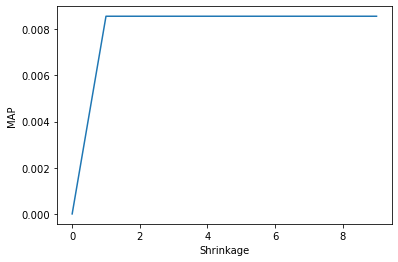

In [32]:
import matplotlib.pyplot as pyplot
%matplotlib inline 
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

### Top Popular Items - Non Personalized Recommender

### User to recommend

In [61]:
urm_train_validation = urm_train + urm_val
TPKNN_recommender = TopPopularKNN()
TPKNN_recommender.fit(urm_train_validation.tocsc())

In [62]:
submission = dm.prepare_submission(ratings, urm_train_validation, TPKNN_recommender)

In [63]:
submission

[(0, [24075, 25407, 25675, 9438, 19089, 10269, 12061, 2426, 25693, 23154]),
 (1, [24075, 25407, 25675, 9438, 19089, 10269, 12061, 2426, 25693, 23154]),
 (2, [24075, 25407, 25675, 9438, 19089, 10269, 12061, 2426, 23154, 25693]),
 (3, [24075, 25407, 25675, 9438, 19089, 10269, 12061, 2426, 23154, 25693]),
 (4, [24075, 25407, 25675, 9438, 19089, 10269, 12061, 2426, 23154, 25693]),
 (5, [24075, 25407, 25675, 9438, 19089, 10269, 12061, 2426, 25693, 23154]),
 (6, [24075, 25407, 25675, 9438, 19089, 10269, 12061, 2426, 23154, 25693]),
 (7, [24075, 25407, 25675, 9438, 19089, 10269, 12061, 2426, 25693, 23154]),
 (8, [24075, 25407, 25675, 9438, 19089, 10269, 12061, 2426, 25693, 23154]),
 (9, [24075, 25407, 25675, 9438, 19089, 10269, 12061, 2426, 25693, 23154]),
 (10, [24075, 25407, 25675, 9438, 19089, 10269, 12061, 2426, 25693, 23154]),
 (11, [24075, 25407, 25675, 9438, 19089, 10269, 12061, 2426, 25693, 23154]),
 (12, [24075, 25407, 25675, 9438, 19089, 10269, 12061, 2426, 23154, 25693]),
 (13, [24

### Evaluator

In [67]:
from modUtils import evaluator as ev

In [68]:
%%time

accum_precision, accum_recall, accum_map, num_user_evaluated, num_users_skipped = ev.evaluate(TPKNN_recommender,
                                                                                            urm_train_validation,
                                                                                            urm_test)

Wall time: 5.68 s


In [69]:
accum_precision, accum_recall, accum_map, num_user_evaluated, num_users_skipped

(0.00697175545227033, 0.022929344510816428, 0.010566511936942859, 5594, 2353)

### Create final submission file

In [60]:
from datetime import date
today = date.today().strftime("TopPopularKNN_%d-%m-%y")
dm.write_submission(submission, today)